In [21]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../')

import os
import pandas as pd
from tqdm import tqdm
import os
import requests
import json
import numpy as np
import urllib.parse

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load and parse CSV

Skip these if using pickle files.

In [22]:
df_netflix_imdb = pd.read_csv('netflix_imdb.csv', index_col=0)

df_netflix_imdb.head()

,netflix_id,imdb_ids,netflix_title,imdb_titles,netflix_year,imdb_years,imdb_scores,tmdb_ids
0,1,['tt0389605' 'tt0447606' 'tt11623870'],Dinosaur Planet,['Dinosaur Planet' 'Bikini Girls on Dinosaur P...,2003,[2003 2005 2003],[1. 0.45289855 0.43478261],[None 58691 None]
1,2,[],Isle of Man TT 2004 Review,[],2004,[],[],[]
2,3,['tt0119448' 'tt0447653'],Character,['Character' 'Kids for Character'],1997,[1997 1996],[1. 0.55555556],[17139 None]
3,4,['tt0276981' 'tt6066714'],Paula Abdul's Get Up & Dance,['Get Up and Dance!' 'Sesame Street: Get Up an...,1994,[1994 1997],[0.57777778 0.33349027],[274766 None]
4,5,['tt0440751' 'tt0864944'],The Rise and Fall of ECW,['The Rise & Fall of ECW' 'Ancient Rome: The R...,2004,[2004 2006],[0.91304348 0.44934641],[33209 None]


In [23]:
# print out

for i in range(5):
    row = df_netflix_imdb.iloc[i]
    ids, scores, sub_ids = row['imdb_ids'], row['imdb_scores'], row['tmdb_ids']
    print(ids, scores, sub_ids)

['tt0389605' 'tt0447606' 'tt11623870'] [1.         0.45289855 0.43478261] [None 58691 None]
[] [] []
['tt0119448' 'tt0447653'] [1.         0.55555556] [17139 None]
['tt0276981' 'tt6066714'] [0.57777778 0.33349027] [274766 None]
['tt0440751' 'tt0864944'] [0.91304348 0.44934641] [33209 None]


In [24]:
converters = {
    "netflix_id": lambda x: int(x), 
    "imdb_ids": lambda x: x.strip("[]").strip("'").strip('"').replace("' '", "|").replace('" "', '|').split("|"), 
    "imdb_titles": lambda x: x.strip("[]").strip("'").strip('"').replace("\n", "").replace("\'", "'").replace('" \'', "|").replace('\' "', "|").replace("' '", "|").replace('" "', '|').split("|"), 
    "netflix_year": lambda x: int(x), 
    "imdb_years": lambda x: [int(num) if num.isdigit() else None for num in x.strip("[]").split(" ")], 
    "imdb_scores": lambda x: [float(num) for num in x.strip("[]").split(" ") if num != ''], 
    "tmdb_ids": lambda x: [int(num) if num.isdigit() else None for num in x.strip("[]").split(" ")]
}

df_netflix_imdb = pd.read_csv("netflix_imdb.csv", index_col=0, converters=converters)

df_netflix_imdb.head()

,netflix_id,imdb_ids,netflix_title,imdb_titles,netflix_year,imdb_years,imdb_scores,tmdb_ids
0,1,"[tt0389605, tt0447606, tt11623870]",Dinosaur Planet,"[Dinosaur Planet, Bikini Girls on Dinosaur Pla...",2003,"[2003, 2005, 2003]","[1.0, 0.45289855, 0.43478261]","[None, 58691, None]"
1,2,[],Isle of Man TT 2004 Review,[],2004,[None],[],[None]
2,3,"[tt0119448, tt0447653]",Character,"[Character, Kids for Character]",1997,"[1997, 1996]","[1.0, 0.55555556]","[17139, None]"
3,4,"[tt0276981, tt6066714]",Paula Abdul's Get Up & Dance,"[Get Up and Dance!, Sesame Street: Get Up and ...",1994,"[1994, 1997]","[0.57777778, 0.33349027]","[274766, None]"
4,5,"[tt0440751, tt0864944]",The Rise and Fall of ECW,"[The Rise & Fall of ECW, Ancient Rome: The Ris...",2004,"[2004, 2006]","[0.91304348, 0.44934641]","[33209, None]"


In [25]:
df_netflix_imdb["imdb_ids"] = df_netflix_imdb.apply(lambda x: [] if len(x['imdb_scores']) == 0 else x["imdb_ids"], axis=1)
df_netflix_imdb["tmdb_ids"] = df_netflix_imdb.apply(lambda x: [] if len(x['imdb_scores']) == 0 else x["tmdb_ids"], axis=1)

# print out

for i in range(10):
    row = df_netflix_imdb.iloc[i]
    ids, scores, sub_ids = row['imdb_ids'], row['imdb_scores'], row['tmdb_ids']
    print(ids, scores, sub_ids)

['tt0389605', 'tt0447606', 'tt11623870'] [1.0, 0.45289855, 0.43478261] [None, 58691, None]
[] [] []
['tt0119448', 'tt0447653'] [1.0, 0.55555556] [17139, None]
['tt0276981', 'tt6066714'] [0.57777778, 0.33349027] [274766, None]
['tt0440751', 'tt0864944'] [0.91304348, 0.44934641] [33209, None]
['tt0120126'] [1.0] [35638]
['tt0182668', 'tt0124971'] [1.0, 0.52083333] [196685, None]
[] [] []
['tt0101591', 'tt6699632', 'tt0090849', 'tt6700280'] [0.60526316, 0.38720539, 0.38440463, 0.32267116] [26230, None, 26554, None]
['tt0416499'] [0.31160968660968663] [21115]


In [26]:
df_netflix_tmdb = pd.read_csv('netflix_tmdb.csv', index_col=0)

df_netflix_tmdb.tail(10)

,netflix_id,tmdb_ids,netflix_title,tmdb_titles,netflix_year,tmdb_years,tmdb_scores,imdb_ids
17760,17761,[21052],Levity,['Levity'],2003,[2003],[1.0],['tt0304328']
17761,17762,[782],Gattaca,['Gattaca'],1997,[1997],[1.0],['tt0119177']
17762,17763,[ 15867 459762],Interiors,['Interiors' 'Interieur Interiors (To A-K)'],1978,[1978 1978],[1. 0.48648649],['tt0077742' '']
17763,17764,[1934],Shakespeare in Love,['Shakespeare in Love'],1998,[1998],[1.0],['tt0138097']
17764,17765,[],Godzilla's Revenge,[],1969,[],[],[]
17765,17766,[175484],Where the Wild Things Are and Other Maurice Se...,['Where the Wild Things Are... and other Mauri...,2002,[2001],[0.8123249299719888],['']
17766,17767,[409774],Fidel Castro: American Experience,['Fidel Castro'],2004,[2005],[0.4444444444444445],['tt0815934']
17767,17768,[20004],Epoch,['Epoch'],2000,[2001],[0.8333333333333334],['tt0233657']
17768,17769,[52036],The Company,['The Company'],2003,[2003],[1.0],['tt0335013']
17769,17770,[22076],Alien Hunter,['Alien Hunter'],2003,[2003],[1.0],['tt0327409']


In [27]:
# print out

for i in range(17760, 17770):
    row = df_netflix_tmdb.iloc[i]
    ids, scores, sub_ids = row['tmdb_ids'], row['tmdb_scores'], row['imdb_ids']
    print(ids, scores, sub_ids)

[21052] [1.0] ['tt0304328']
[782] [1.0] ['tt0119177']
[ 15867 459762] [1.         0.48648649] ['tt0077742' '']
[1934] [1.0] ['tt0138097']
[] [] []
[175484] [0.8123249299719888] ['']
[409774] [0.4444444444444445] ['tt0815934']
[20004] [0.8333333333333334] ['tt0233657']
[52036] [1.0] ['tt0335013']
[22076] [1.0] ['tt0327409']


In [28]:
converters = {
    "netflix_id": lambda x: int(x), 
    "tmdb_ids": lambda x: [int(num) for num in x.strip("[]").split(" ") if num.isdigit()], 
    "tmdb_titles": lambda x: x.strip("[]").strip("'").strip('"').replace("\n", "").replace("\'", "'").replace('" \'', "|").replace('\' "', "|").replace("' '", "|").replace('" "', '|').split("|"), 
    "netflix_year": lambda x: int(x), 
    "tmdb_years": lambda x: [int(num) for num in x.strip("[]").split(" ") if num.isdigit()], 
    "tmdb_scores": lambda x: [float(num) for num in x.strip("[]").split(" ") if num != ''], 
    "imdb_ids": lambda x: [id if id != 'None' else None for id in x.strip("[]").replace("''", "None").replace("'", "").split(" ")]
}

df_netflix_tmdb = pd.read_csv("netflix_tmdb.csv", index_col=0, converters=converters)

df_netflix_tmdb.head()

,netflix_id,tmdb_ids,netflix_title,tmdb_titles,netflix_year,tmdb_years,tmdb_scores,imdb_ids
0,1,[58691],Dinosaur Planet,[Bikini Girls on Dinosaur Planet],2003,[2005],[0.4528985507246377],[tt0447606]
1,2,[],Isle of Man TT 2004 Review,[],2004,[],[],[]
2,3,"[17139, 1151430]",Character,"[Character, CHARACTER]",1997,"[1997, 2002]","[1.0, 0.40187757]","[tt0119448, tt3362034]"
3,4,[274766],Paula Abdul's Get Up & Dance,[Paula Abdul's Get Up & Dance],1994,[1994],[1.0],[tt0276981]
4,5,[33209],The Rise and Fall of ECW,[WWE: The Rise + Fall of ECW],2004,[2004],[0.8235294117647058],[tt0440751]


In [29]:
df_netflix_tmdb["imdb_ids"] = df_netflix_tmdb.apply(lambda x: [] if len(x['tmdb_scores']) == 0 else x["imdb_ids"], axis=1)
df_netflix_tmdb["tmdb_ids"] = df_netflix_tmdb.apply(lambda x: [] if len(x['tmdb_scores']) == 0 else x["tmdb_ids"], axis=1)

# print out

for i in range(17760, 17763):
    row = df_netflix_tmdb.iloc[i]
    ids, scores, sub_ids = row['tmdb_ids'], row['tmdb_scores'], row['imdb_ids']
    print(ids, scores, sub_ids)

[21052] [1.0] ['tt0304328']
[782] [1.0] ['tt0119177']
[15867, 459762] [1.0, 0.48648649] ['tt0077742', None]


In [30]:
type(sub_ids[1])

NoneType

In [31]:
df_netflix_tmdb.to_pickle('netflix_tmdb.pickle')
df_netflix_imdb.to_pickle('netflix_imdb.pickle')

# Load pickle

In [32]:
df_netflix_imdb = pd.read_pickle("netflix_imdb.pickle")
df_netflix_tmdb = pd.read_pickle("netflix_tmdb.pickle")

In [33]:
# # print out

# for i in range(10):
#     row = df_netflix_imdb.iloc[i]
#     ids, scores, sub_ids = row['imdb_ids'], row['imdb_scores'], row['tmdb_ids']
#     print(ids, scores, sub_ids)

In [34]:
# # print out

# for i in range(10):
#     row = df_netflix_tmdb.iloc[i]
#     ids, scores, sub_ids = row['tmdb_ids'], row['tmdb_scores'], row['imdb_ids']
#     print(ids, scores, sub_ids)

# Matching

In [35]:
df_netflix_imdb = pd.read_pickle("netflix_imdb.pickle")
df_netflix_tmdb = pd.read_pickle("netflix_tmdb.pickle")

In [36]:
threshold_imdb = 0.8
threshold_tmdb = 0.8

df_netflix_imdb_tmdb = pd.DataFrame(columns=['netflix_id', 'imdb_id', 'tmdb_id', 
                                             'netflix_title', 'imdb_title', 'tmdb_title', 
                                             'netflix_year', 'imdb_year', 'tmdb_year', 
                                             'imdb_score', 'tmdb_score', 'confidence_score'])

for i in tqdm(range(17770)):
# for i in tqdm(range(17770)):
    row_L, row_R = df_netflix_imdb.iloc[i], df_netflix_tmdb.iloc[i]

    ids_L, scores_L, sub_ids_L = row_L['imdb_ids'], row_L['imdb_scores'], row_L['tmdb_ids']
    ids_R, scores_R, sub_ids_R = row_R['tmdb_ids'], row_R['tmdb_scores'], row_R['imdb_ids']

    nid, ntt, nyr = row_L['netflix_id'], row_L['netflix_title'], row_L['netflix_year']
    iid, itt, iyr, isc = None, None, None, None
    tid, ttt, tyr, tsc = None, None, None, None
    sc = None

    if len(ids_L) == 0 and len(ids_R) == 0:
        pass
    elif len(ids_L) == 0: # only tmdb
        if scores_R[0] > threshold_tmdb:
            if len(ids_R) > 1 and scores_R[0] == scores_R[1]:
                pass
            else:
                tid, ttt, tyr, tsc = ids_R[0], row_R['tmdb_titles'][0], row_R['tmdb_years'][0], scores_R[0]
                iid = sub_ids_R[0] if isinstance(sub_ids_R[0], str) else None
                sc = tsc
    elif len(ids_R) == 0: # only imdb
        if scores_L[0] > threshold_imdb:
            if len(ids_L) > 1 and scores_L[0] == scores_L[1]:
                pass
            else:
                iid, itt, iyr, isc = ids_L[0], row_L['imdb_titles'][0], row_L['imdb_years'][0], scores_L[0]
                tid = sub_ids_L[0] if isinstance(sub_ids_L[0], str) else None
                sc = isc
    else: # if imdb tmdb info both exist
        # if set(ids_L).isdisjoint(sub_ids_R) and set(ids_R).isdisjoint(sub_ids_L): # if they do NOT have shared movie
        if scores_L[0] >= scores_R[0]:
            if scores_L[0] > threshold_imdb:
                if len(ids_L) > 1 and scores_L[0] == scores_L[1]:
                    pass
                else:
                    iid, itt, iyr, isc = ids_L[0], row_L['imdb_titles'][0], row_L['imdb_years'][0], scores_L[0]
                    tid = sub_ids_L[0] if isinstance(sub_ids_L[0], int) else None
                    if tid in ids_R:
                        idx = ids_R.index(tid)
                        ttt, tyr, tsc = row_R['tmdb_titles'][idx], row_R['tmdb_years'][idx], scores_R[idx]
                    sc = isc
        elif scores_R[0] > scores_L[0]:
            if scores_R[0] > threshold_tmdb:
                if len(ids_R) > 1 and scores_R[0] == scores_R[1]:
                    pass
                else:
                    tid, ttt, tyr, tsc = ids_R[0], row_R['tmdb_titles'][0], row_R['tmdb_years'][0], scores_R[0]
                    iid = sub_ids_R[0] if isinstance(sub_ids_R[0], str) else None
                    if iid in ids_L:
                        idx = ids_L.index(iid)
                        itt, iyr, isc = row_L['imdb_titles'][idx], row_L['imdb_years'][idx], scores_L[idx]
                    sc = tsc

    df_netflix_imdb_tmdb.loc[len(df_netflix_imdb_tmdb.index)] = [nid, iid, tid, ntt, itt, ttt, nyr, iyr, tyr, isc, tsc, sc]

100%|██████████| 17770/17770 [01:10<00:00, 253.23it/s]


In [41]:
df_netflix_imdb_tmdb.to_pickle('netflix_imdb_tmdb.pickle')
df_netflix_imdb_tmdb.to_csv('netflix_imdb_tmdb.csv')

# Preview

In [42]:
df_netflix_imdb_tmdb.tail(50)

,netflix_id,imdb_id,tmdb_id,netflix_title,imdb_title,tmdb_title,netflix_year,imdb_year,tmdb_year,imdb_score,tmdb_score,confidence_score
17720,17721,tt0140340,57943,The Love Letter,The Love Letter,The Love Letter,1998,1998,1998,1.0,1.0,1.0
17721,17722,None,None,Faerie Tale Theatre: The Little Mermaid,None,None,1984,None,None,None,None,None
17722,17723,tt0275624,217813,Redemption,None,Redemption,2004,None,2003,None,0.833333,0.833333
17723,17724,tt0107007,10655,Gettysburg,Gettysburg,Gettysburg,1993,1993,1993,1.0,1.0,1.0
17724,17725,tt0500140,23319,Jerry Seinfeld: I'm Telling You for the Last Time,Jerry Seinfeld: 'I'm Telling You for the Last ...,Jerry Seinfeld: I'm Telling You for the Last Time,1999,1998,1998,0.816667,0.833333,0.833333
17725,17726,tt0173714,26598,Cats,Cats,Cats,1998,1998,1998,1.0,1.0,1.0
17726,17727,None,None,Elizabeth Taylor: The Last Time I Saw Paris/Fa...,None,None,1954,None,None,None,None,None
17727,17728,tt0218433,120683,Me & Isaac Newton,Me & Isaac Newton,Me & Isaac Newton,2000,1999,2000,0.833333,1.0,1.0
17728,17729,tt0179861,15090,Icebreaker,Icebreaker,Icebreaker,1999,2000,2000,0.833333,0.833333,0.833333
17729,17730,tt0051418,8851,The Blob,The Blob,The Blob,1958,1958,1958,1.0,1.0,1.0


<AxesSubplot:>

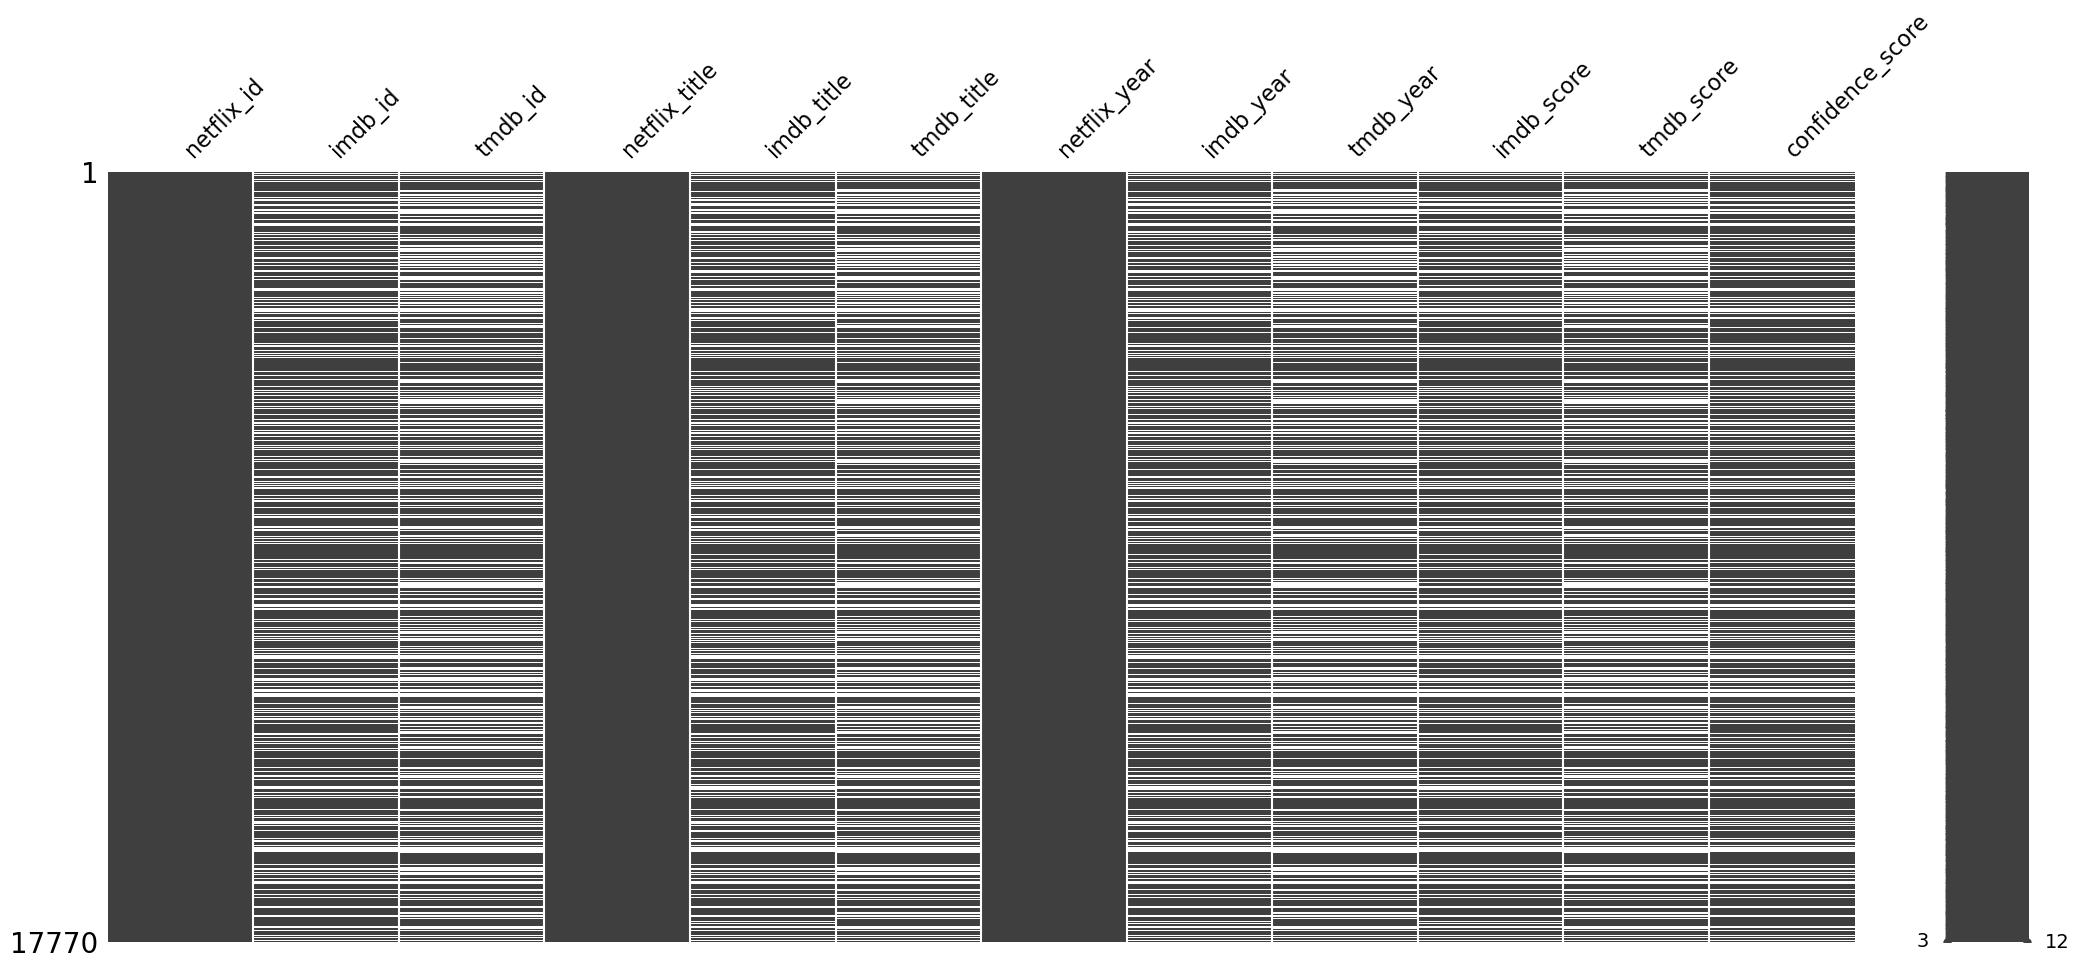

In [43]:
import missingno as msno

msno.matrix(df_netflix_imdb_tmdb)

<AxesSubplot:>

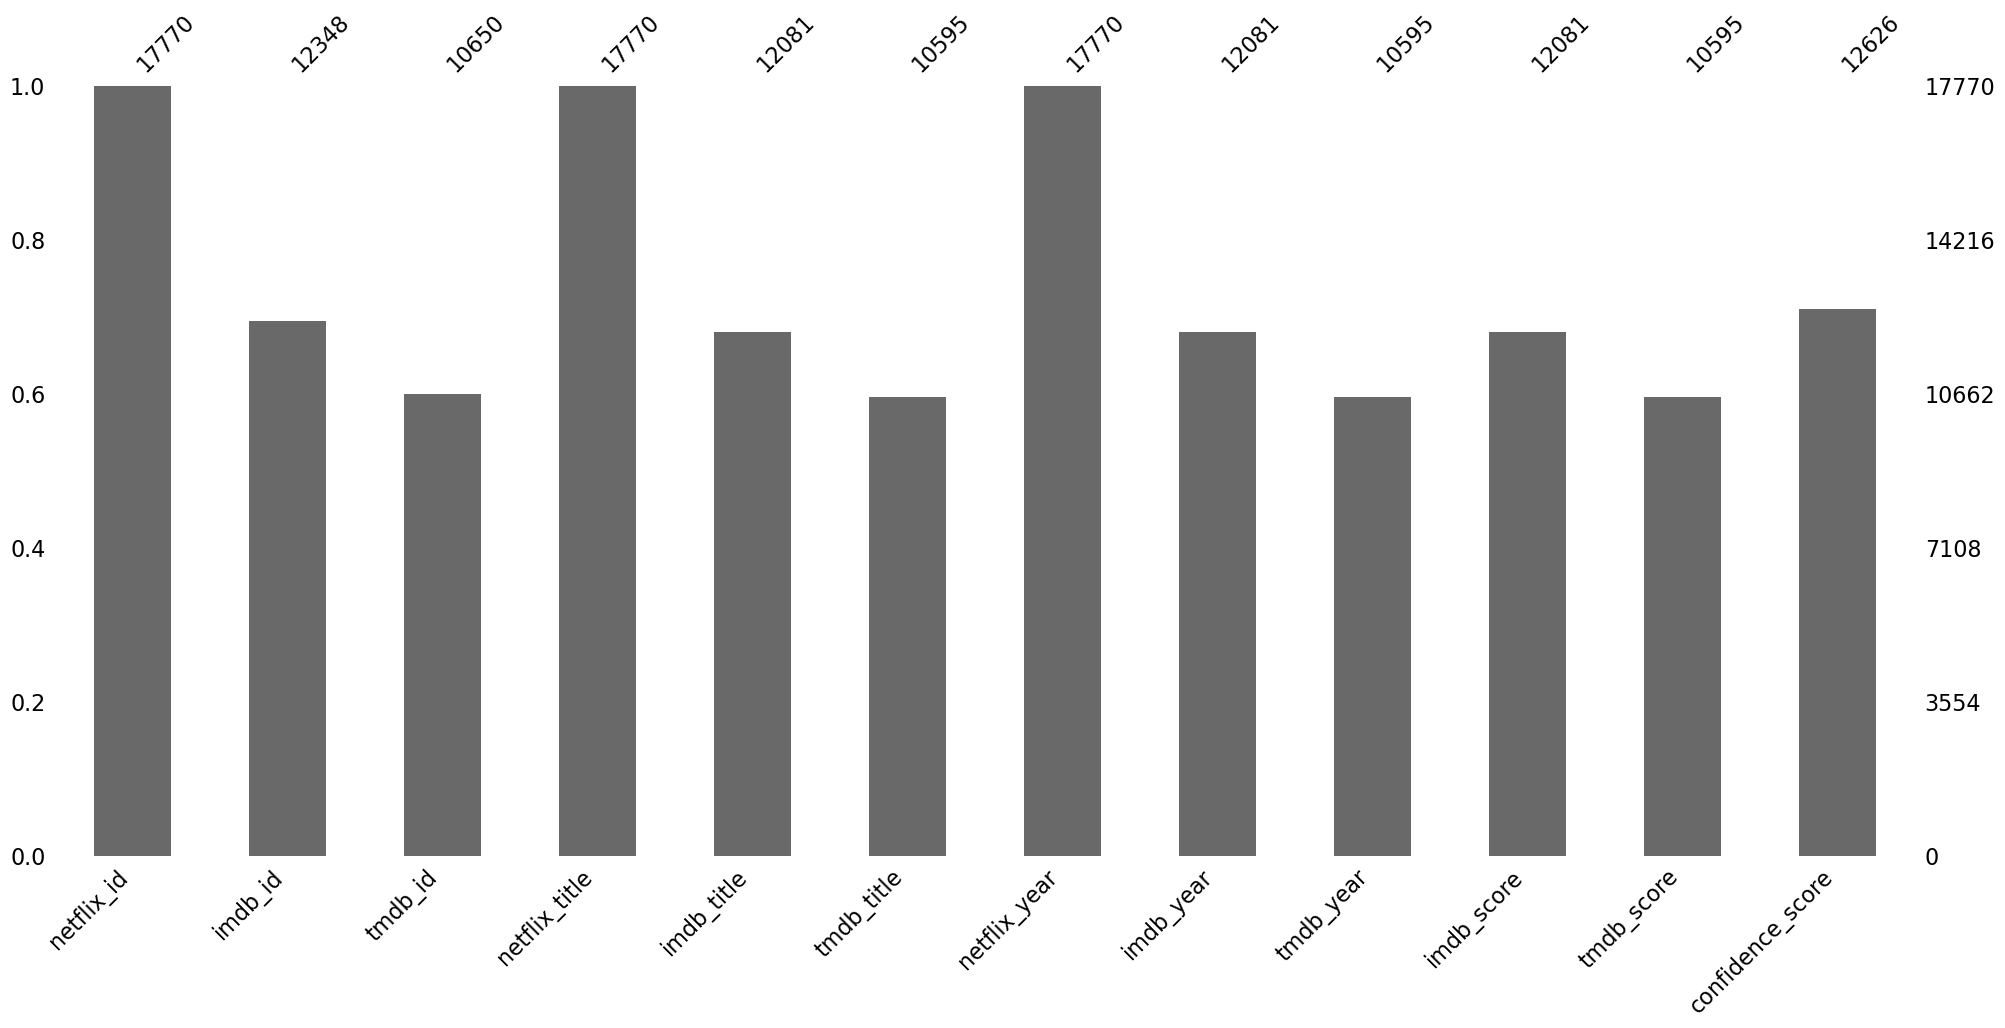

In [44]:
msno.bar(df_netflix_imdb_tmdb)